# LSTM and Bidirectional LSTM Model Pipeline
**MIDS W210 Capstone | Find Your Rhythm**

Test Example: model_inputs_fyr-recordings_fyr-beat-120.wav recorded by Andrew

Below is two method for data pipeline:
1. Method 1: Used for data pipeline with model trained using fit_generator(save memory for large dataset)
2. Method 2: Used for data pipeline with model trained using fit

In [ ]:
from google.cloud import storage

# Basic packages 
import pickle
import librosa
import IPython.display as ipd
import numpy as np
from os import listdir
import os
import sys
import math
import random

# Plot Package
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import clear_output

# Model Package
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation,LSTM, TimeDistributed, Bidirectional
from keras.regularizers import l2
from keras import callbacks
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

## 1. Audio Play

## 2. Data Pipeline
### Method 1: data pipeline with model trained using fit_generator
Model: trained by egmd_SF1000 dataset

**Predict Labels Using BiLSTM Model**
1. Predict onset probability using BiLSTM Model with outcome size (batch size, segment length, no of instruments) using KerasBatchGenerator
2. Concatecate all batches into one song with size of (number of frames, no of instruments)
3. Peak pick method: evaluate onset with predicted outcomes at each frame for each instrument based on pick peak method

In [ ]:
# Applied for fit_generator to save memory
class KerasBatchGenerator(object):
    def __init__(self, data, num_steps, num_features, batch_size, num_class, skip_step=5):
        self.data = data  #Train, validation, test dataset
        self.num_steps = num_steps  # segment length
        self.num_features = num_features # no of frequency bins
        self.batch_size = batch_size   # size of the batch
        self.num_class = num_class  # no of different Drum Instruments 
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0  # track progress of batches, once dataset reaches the end, it resets to zero
        # THis determines overlap for two sequential segment, if skip step = num step, there is no overlap
        self.skip_step = skip_step

    def generate(self):
        """Output Train and Validation Dataset and Labels
        Train Dataset Dimentsion: Batch Size, Segment Length, no of frequency bin
        Train Label Dimension: Batch Size, Segment Length, no of drum instrument"""
        self.x = np.zeros((self.batch_size, self.num_steps, self.num_features))
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                  # reset the index back to the start of the data set
                   self.current_idx = 0
                self.x[i, :, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                self.current_idx += self.skip_step
            yield self.x

In [ ]:
def preprocessor(file, sr=22050, hop_length=512, seg_len=5, representation='stft'):
    """
    Preprocesing steps for raw data file transformation into model input.
    """
    # convert segmentLength in second into integer if a float value is provided
    segment_length = int(seg_len)
    # load the wav file into an audio time series array
    wav, sr = librosa.load(file, sr = sr)
    # length of the full wav array
    wav_len = len(wav)
    # create an array representation of the wav audio data
    if representation == 'stft':
        # transpose the stft array so that rows represent each frame in time and features (columns) are frequency bins
        data = np.absolute(librosa.stft(wav)).transpose()
    elif representation == 'cqt':
        # transpose the cqt array so that rows represent each frame in time and features (columns) are frequency bins
        data = np.absolute(librosa.cqt(wav, sr=sr)).transpose()
    # pad the end of the audio with silence depending on the sequence length
    number_frames = data.shape[0]
    # Transfer segment length in sec to segment length in frame
    segmentLength = librosa.time_to_frames(segment_length, sr=sr)
    # calculate how much silence should be added in last segment
    remaining_frames = int(segmentLength-(number_frames % segmentLength))
    # if the audio can not fill the frames of last segment, silence is padded on to the end of the segment
    if remaining_frames != segmentLength:
        # attach zeros to the end of row of stft to make sure two songs are not merged within one segment 
        data = np.append(data,np.zeros((remaining_frames, data.shape[1])),axis=0)
    arr_out = np.asarray(data)
   
    return arr_out, segmentLength  

In [ ]:
def Pred_Segment(file, threshold, x_test = x_test, segmentLength = segmentLength, number_classes = number_classes):
    """
    Predict onset probability and evaluate onset point based on peak pick method
    """
    model = load_model(file)
    # this is to control where in the data-set the comparison audio are drawn from
    dummy_iters = 0
    example_training_generator = KerasBatchGenerator(x_test, segmentLength, x_test.shape[1], batch_size=1, num_class=number_classes,
                                               skip_step=segmentLength)

    for i in range(dummy_iters):
        dummy = next(example_training_generator.generate())

    num_predict = int(x_test.shape[0]/segmentLength)

    for i in range(num_predict):
        data = next(example_training_generator.generate())
        prediction = model.predict(data)

        if i == 0:
            prediction_concat = prediction[0]
        else:
            prediction_concat = np.concatenate((prediction_concat,prediction[0]))


    T = threshold
    predicts =  np.zeros(prediction_concat.shape)
    
    for i in range(prediction_concat.shape[0]):
        for j in range(prediction_concat.shape[1]):
            if (i != 0) and (i != prediction_concat.shape[0]-1):
                if (prediction_concat[i][j]>prediction_concat[i-1][j]) and (prediction_concat[i][j]>=prediction_concat[i+1][j]) and (prediction_concat[i][j]>T[j]):
                    predicts[i][j] = 1
                else:
                    predicts[i][j] = 0
            else:
                predicts[i][j] = 0
    return predicts

**Check Training Data Labels Index**

In [ ]:
file_name = 'labels.pkl'
VM_folder = 'model_input/egmd_SF1000/'
gcp_folder='model_inputs/egmd_SF1000/'
with open(VM_folder + file_name, 'rb') as file:
    dict_keys = pickle.load(file)
print(dict_keys)

[38, 35, 42, 44, 51, 37, 43, 50, 46, 53, 54, 47, 49, 39, 56, 41, 48, 52, 55]


In [ ]:
# Instrument pitch is ordered based on label counts collected in mdb and idmt database
midi_classes = {35: 'Acoustic Bass Drum', 36: 'Bass Drum 1', 37: 'Side Stick', 38: 'Acoustic Snare', 39: 'Hand Clap', 
                40: 'Electric Snare', 41: 'Low Floor Tom', 42: 'Closed Hi Hat', 43: 'High Floor Tom', 44: 'Pedal Hi-Hat', 
                45: 'Low Tom', 46: 'Open Hi-Hat', 47: 'Low-Mid Tom', 48: 'Hi-Mid Tom', 49: 'Crash Cymbal 1', 
                50: 'High Tom',  51: 'Ride Cymbal 1', 52: 'Chinese Cymbal', 53: 'Ride Bell', 54: 'Tambourine', 
                55: 'Splash Cymbal', 56: 'Cowbell', 57: 'Crash Cymbal 2', 58: 'Vibraslap', 59: 'Ride Cymbal 2', 
                60: 'Hi Bongo', 61: 'Low Bongo', 62: 'Mute Hi Conga', 63: 'Open Hi Conga', 64: 'Low Conga', 
                65: 'High Timbale', 66: 'Low Timbale', 67: 'High Agogo', 68: 'Low Agogo', 69: 'Cabasa', 
                70: 'Maracas', 71: 'Short Whistle', 72: 'Long Whistle', 73: 'Short Guiro', 74: 'Long Guiro', 
                75: 'Claves', 76: 'Hi Wood Block', 77: 'Low Wood Block', 78: 'Mute Cuica', 79: 'Open Cuica', 
                80: 'Mute Triangle', 81: 'Open Triangle',
               # to be removed
                22: 'Unknown 22', 26: 'Unknown 26'
               }

inst_labels = []
for inst_t in dict_keys:
    inst_labels.append(midi_classes[inst_t])
print(inst_labels)

['Acoustic Snare', 'Acoustic Bass Drum', 'Closed Hi Hat', 'Pedal Hi-Hat', 'Ride Cymbal 1', 'Side Stick', 'High Floor Tom', 'High Tom', 'Open Hi-Hat', 'Ride Bell', 'Tambourine', 'Low-Mid Tom', 'Crash Cymbal 1', 'Hand Clap', 'Cowbell', 'Low Floor Tom', 'Hi-Mid Tom', 'Chinese Cymbal', 'Splash Cymbal']


**Preprocess Data**

In [ ]:
file_name = 'model_inputs_fyr-recordings_fyr-beat-120.wav'
x_test, segmentLength = preprocessor(file=file_name, sr=22050, hop_length=512, seg_len=5, representation='stft')
print(x_test.shape)

(1075, 1025)


**Use function Pred_Segment to predict onset with preprocessed audio input using BiLSTM Model**


In [ ]:
# Model Filepath
File_Root = 'model_log/'
database_name = 'egmd_SF1000'
number_units = 500
number_layers = 2
number_classes = 13
num_epochs = 200
batch_size = 80

#Create a folder to restore the state and log file
weights_dir = File_Root + 'BiLSTM_%s_BatchSize_%i_Layers_%i_Nodes_%i_Classes_%i'%(database_name, batch_size, number_layers, number_units, number_classes)
modelname = "/model-40.hdf5"
model_filepath_M1 = weights_dir + modelname

In [ ]:
threshold_M1 = [0.31875417, 0.26601505, 0.21710016, 0.3464365, 0.39170837, 0.4210618, 0.24784555, 0.2743954, 0.47944167, 0.27028206, 0.01171424, 0.09789324, 0.2888664]

In [ ]:
predicts_M1 = Pred_Segment(model_filepath_M1, threshold_M1)

**Plot Onset**

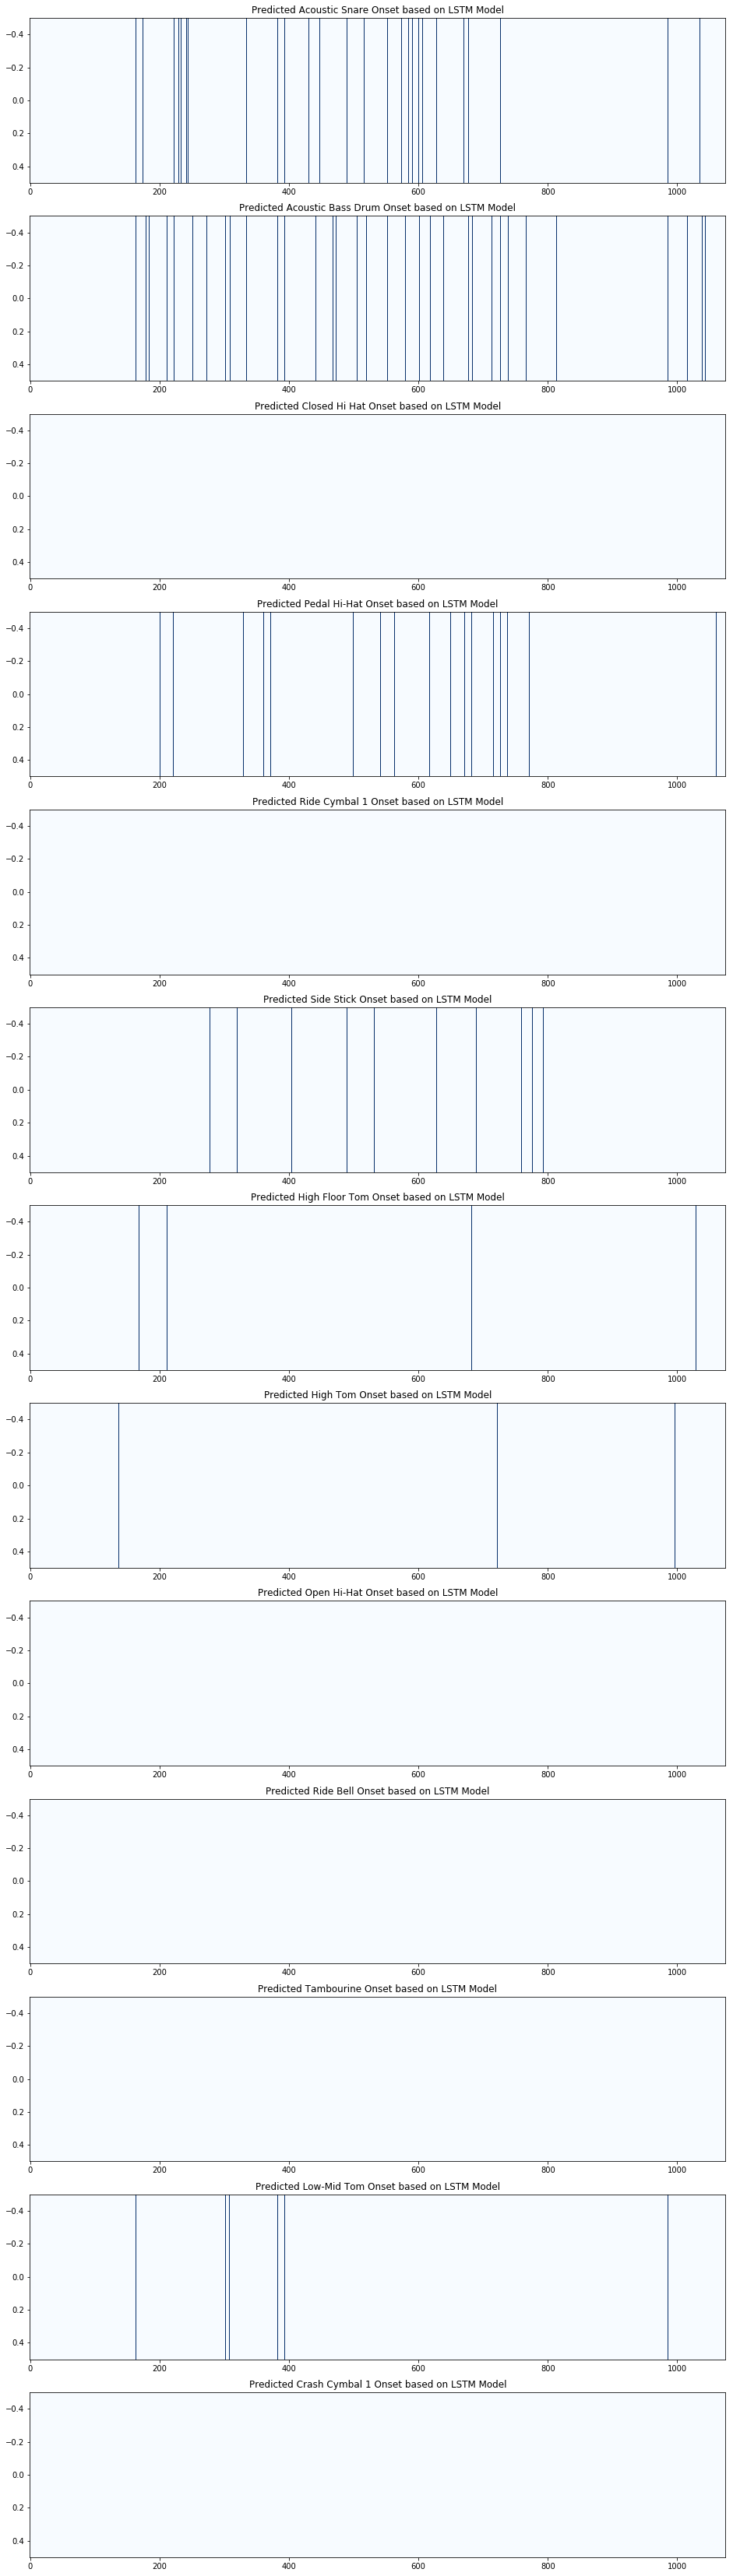

In [ ]:
fig, axes = plt.subplots(number_classes,1, figsize=(16,60))

for ints_idx in range(number_classes):
    axes[ints_idx].set_title('Predicted %s Onset based on LSTM Model'% (inst_labels[ints_idx]))
    axes[ints_idx].imshow(predicts_M1[0:,ints_idx:ints_idx+1].transpose(),cmap='Blues',aspect='auto', interpolation = 'nearest')
# axes[2].set_xticklabels(range(4950,5250,50))

### Method 2: data pipeline with model trained using fit
Model: trained by mdb_idmt_egmd1000 dataset

**Predict Labels Using BiLSTM Model**
1. Predict onset probability using BiLSTM Model with outcome size (batch size, segment length, no of instruments) using KerasSegmentGenerator
2. Concatecate all batches into one song with size of (number of frames, no of instruments)
3. Peak pick method: evaluate onset with predicted outcomes at each frame for each instrument based on pick peak method

In [ ]:
class KerasSegmentGenerator(object):
    def __init__(self, data, num_steps, num_features, skip_step=5):
        self.data = data  #Train, validation, test dataset
        self.num_steps = num_steps  # segment length
        self.num_features = num_features # no of feature bins
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0  # track progress of batches, once dataset reaches the end, it resets to zero
        # THis determines overlap for two sequential segment, if skip step = num step, there is no overlap
        self.skip_step = skip_step

    def generate(self):
        """Output Train and Validation Dataset and Labels
        Train Dataset Dimentsion: Batch Size, Segment Length, no of frequency bin
        Train Label Dimension: Batch Size, Segment Length, no of drum instrument"""
        self.interations = int(len(self.data)/self.num_steps)
        self.x = np.zeros((self.interations, self.num_steps, self.num_features))
        
        while True:
            for i in range(self.interations):
                if self.current_idx + self.num_steps >= len(self.data):
                  # reset the index back to the start of the data set
                   self.current_idx = 0
                self.x[i, :, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                self.current_idx += self.skip_step
            return self.x

In [ ]:
def preprocessor(file, sr=22050, hop_length=512, seg_len=5, representation='stft'):
    """
    Preprocesing steps for raw data file transformation into model input.
    """
    # convert segmentLength in second into integer if a float value is provided
    segment_length = int(seg_len)
    # load the wav file into an audio time series array
    wav, sr = librosa.load(file, sr = sr)
    # length of the full wav array
    wav_len = len(wav)
    # create an array representation of the wav audio data
    if representation == 'stft':
        # transpose the stft array so that rows represent each frame in time and features (columns) are frequency bins
        data = np.absolute(librosa.stft(wav)).transpose()
    elif representation == 'cqt':
        # transpose the cqt array so that rows represent each frame in time and features (columns) are frequency bins
        data = np.absolute(librosa.cqt(wav, sr=sr)).transpose()
    # pad the end of the audio with silence depending on the sequence length
    number_frames = data.shape[0]
    # Transfer segment length in sec to segment length in frame
    segmentLength = librosa.time_to_frames(segment_length, sr=sr)
    # calculate how much silence should be added in last segment
    remaining_frames = int(segmentLength-(number_frames % segmentLength))
    # if the audio can not fill the frames of last segment, silence is padded on to the end of the segment
    if remaining_frames != segmentLength:
        # attach zeros to the end of row of stft to make sure two songs are not merged within one segment 
        data = np.append(data,np.zeros((remaining_frames, data.shape[1])),axis=0)
    arr_out = np.asarray(data)
    #Model transformations 
    segment_generator = KerasSegmentGenerator(arr_out, segmentLength, arr_out.shape[1], skip_step=segmentLength)
    model_data = segment_generator.generate()
    return model_data  

**Check Training Data Labels Index**

In [ ]:
file_name = 'labels.pkl'
VM_folder = 'model_input/mdb_idmt_egmd1000/'
gcp_folder='model_inputs/mdb_idmt_egmd1000/'
with open(VM_folder + file_name, 'rb') as file:
    dict_keys = pickle.load(file)
print(dict_keys)

[38, 35, 51, 42, 44, 37, 50, 43, 46, 54, 53, 49, 47, 39, 41, 56, 48, 52, 55]


In [ ]:
# Instrument pitch is ordered based on label counts collected in mdb and idmt database
midi_classes = {35: 'Acoustic Bass Drum', 36: 'Bass Drum 1', 37: 'Side Stick', 38: 'Acoustic Snare', 39: 'Hand Clap', 
                40: 'Electric Snare', 41: 'Low Floor Tom', 42: 'Closed Hi Hat', 43: 'High Floor Tom', 44: 'Pedal Hi-Hat', 
                45: 'Low Tom', 46: 'Open Hi-Hat', 47: 'Low-Mid Tom', 48: 'Hi-Mid Tom', 49: 'Crash Cymbal 1', 
                50: 'High Tom',  51: 'Ride Cymbal 1', 52: 'Chinese Cymbal', 53: 'Ride Bell', 54: 'Tambourine', 
                55: 'Splash Cymbal', 56: 'Cowbell', 57: 'Crash Cymbal 2', 58: 'Vibraslap', 59: 'Ride Cymbal 2', 
                60: 'Hi Bongo', 61: 'Low Bongo', 62: 'Mute Hi Conga', 63: 'Open Hi Conga', 64: 'Low Conga', 
                65: 'High Timbale', 66: 'Low Timbale', 67: 'High Agogo', 68: 'Low Agogo', 69: 'Cabasa', 
                70: 'Maracas', 71: 'Short Whistle', 72: 'Long Whistle', 73: 'Short Guiro', 74: 'Long Guiro', 
                75: 'Claves', 76: 'Hi Wood Block', 77: 'Low Wood Block', 78: 'Mute Cuica', 79: 'Open Cuica', 
                80: 'Mute Triangle', 81: 'Open Triangle',
               # to be removed
                22: 'Unknown 22', 26: 'Unknown 26'
               }

inst_labels = []
for inst_t in dict_keys:
    inst_labels.append(midi_classes[inst_t])
print(inst_labels)

['Acoustic Snare', 'Acoustic Bass Drum', 'Ride Cymbal 1', 'Closed Hi Hat', 'Pedal Hi-Hat', 'Side Stick', 'High Tom', 'High Floor Tom', 'Open Hi-Hat', 'Tambourine', 'Ride Bell', 'Crash Cymbal 1', 'Low-Mid Tom', 'Hand Clap', 'Low Floor Tom', 'Cowbell', 'Hi-Mid Tom', 'Chinese Cymbal', 'Splash Cymbal']


**Preprocess Data**

In [ ]:
file_name = 'model_inputs_fyr-recordings_fyr-beat-120.wav'
testx = preprocessor(file=file_name, sr=22050, hop_length=512, seg_len=5, representation='stft')
print(testx.shape)

(5, 215, 1025)


**Use function Pred_Segment to predict onset with preprocessed audio input**

In [ ]:
# Model Filepath
File_Root = 'model_log/'
database_name = 'mdb_idmt_egmd1000'
number_units = 500
number_layers = 2
number_classes = 13
num_epochs = 200
batch_size = 40

#Create a folder to restore the state and log file
weights_dir = File_Root + 'BiLSTM_%s_BatchSize_%i_Layers_%i_Nodes_%i_Classes_%i'%(database_name, batch_size, number_layers, number_units, number_classes)
modelname = "/model-29.hdf5"
model_filepath_M2 = weights_dir + modelname

In [ ]:
def Pred_Segment(file, threshold, testx = testx):
    """
    Predict onset probability and evaluate onset point based on peak pick method
    """
    model = load_model(file)
    prediction = model.predict(testx)


    for i in range(prediction.shape[0]):
        if i == 0:
            prediction_concat = prediction[i, :, :]

        else:
            prediction_concat = np.concatenate((prediction_concat,prediction[i, :, :]))


    T= threshold
    predicts =  np.zeros(prediction_concat.shape)
    for i in range(prediction_concat.shape[0]):
        for j in range(prediction_concat.shape[1]):
            if (i != 0) and (i != prediction_concat.shape[0]-1):
                if (prediction_concat[i][j]>prediction_concat[i-1][j]) and (prediction_concat[i][j]>=prediction_concat[i+1][j]) and (prediction_concat[i][j]>T[j]):
                    predicts[i][j] = 1
                else:
                    predicts[i][j] = 0
            else:
                predicts[i][j] = 0
    return predicts
    

In [ ]:
threshold_M2 = [0.6989163, 0.6494368, 0.4516095,0.5138468,0.3561319,0.18814914,0.08019187,0.08303985, 0.04963303, 0.00304278, 0.01629751, 0.01467455, 0.00192047]
predicts_M2 = Pred_Segment(model_filepath_M2, threshold_M2)

**Plot Onset**

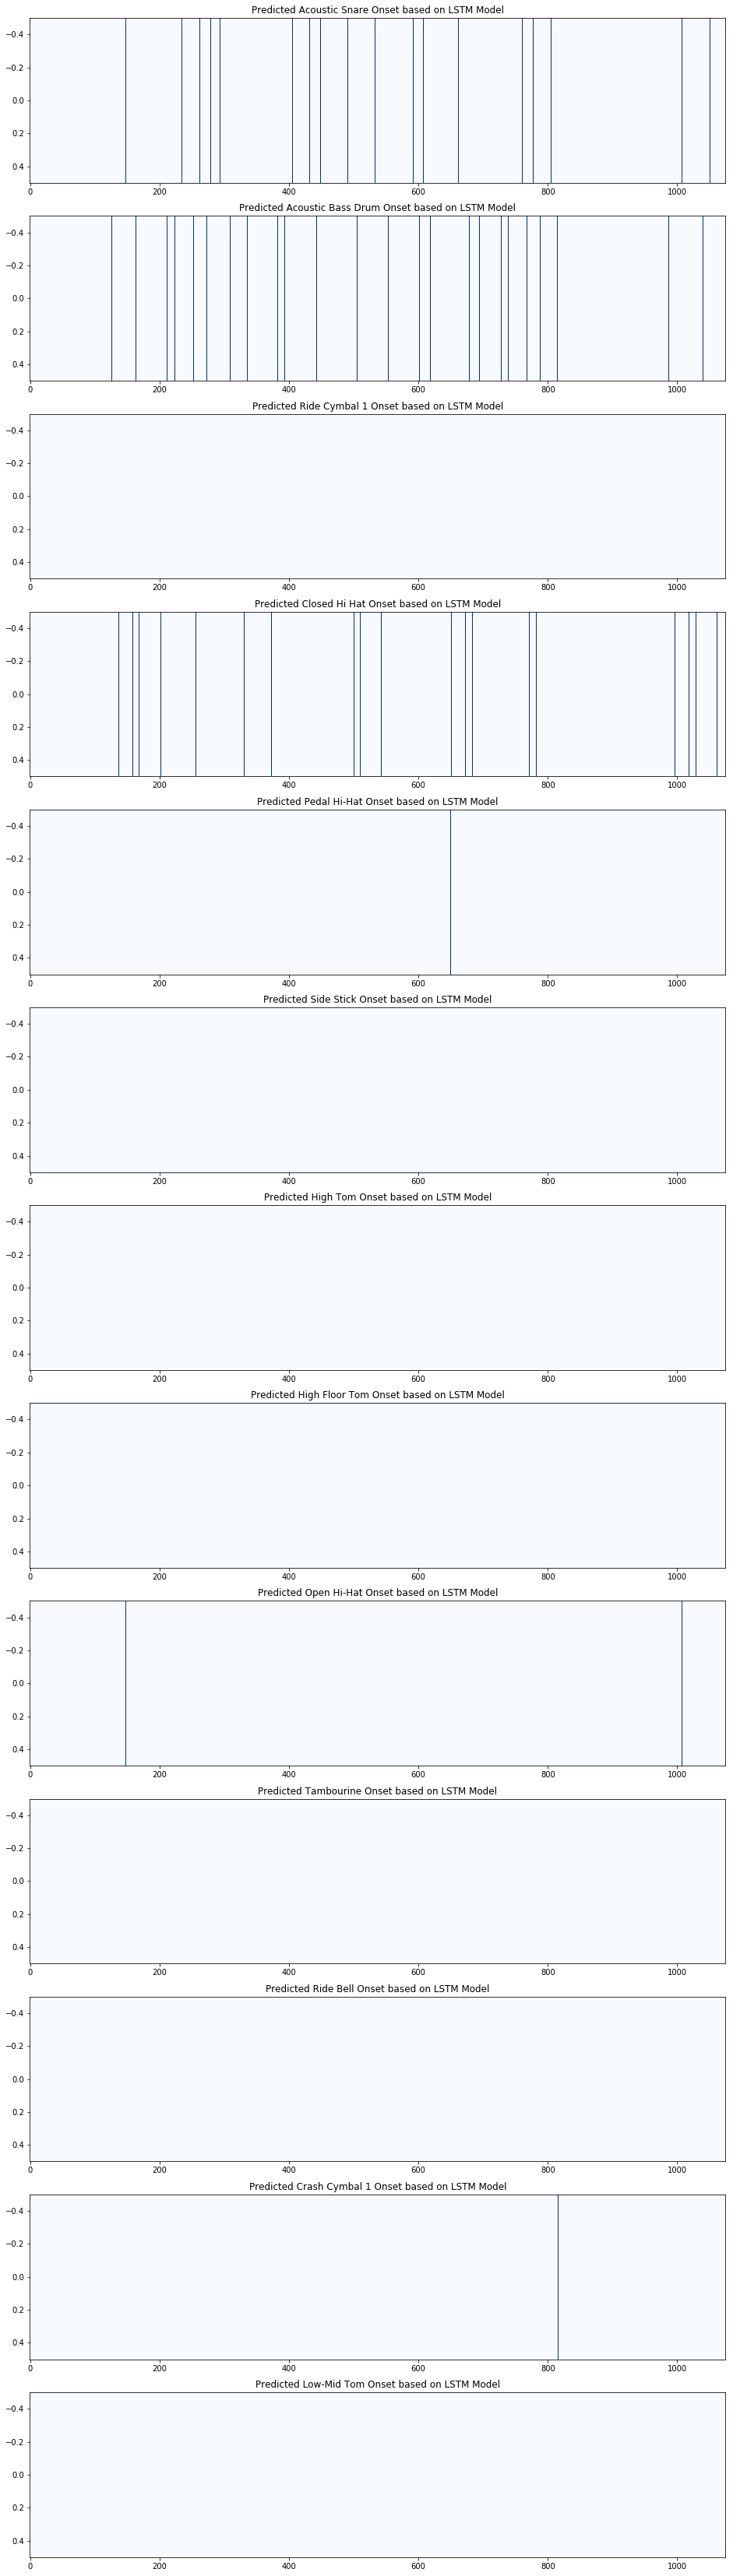

In [ ]:
fig, axes = plt.subplots(number_classes,1, figsize=(16,60))

for ints_idx in range(number_classes):
    axes[ints_idx].set_title('Predicted %s Onset based on LSTM Model'% (inst_labels[ints_idx]))
    axes[ints_idx].imshow(predicts_M2[0:,ints_idx:ints_idx+1].transpose(),cmap='Blues',aspect='auto', interpolation = 'nearest')
# axes[2].set_xticklabels(range(4950,5250,50))